In [1]:
import torch 
import numpy as np
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
sys.path.append("..\\")
plt.style.use("dark_background")
device = "cuda"
from score_models import ScoreModel, NCSNpp

In [26]:
score_model = ScoreModel(checkpoints_directory="../ncsnpp_probes_g_64_230604024652")
img = score_model.sample(1, shape = (1, 64, 64), steps = 500)

100%|██████████| 500/500 [00:24<00:00, 20.75it/s]


Text(0.5, 1.0, 'Inverse FFT')

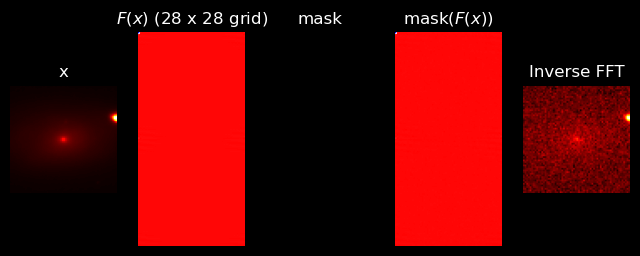

In [28]:
p = 1

x = img[0, 0, ...]
img_size = x.shape[-1]
mask = torch.bernoulli(p * torch.ones(img_size ** 2)).type(torch.bool)
mask = torch.cat([mask, mask], dim = 0).to(device)
obs_dim = mask.sum().item()

sigma_likelihood = 0.1
dist_likelihood = torch.distributions.MultivariateNormal(loc = torch.zeros(2 * img_size ** 2, device = x.device), covariance_matrix = sigma_likelihood**2 * torch.eye(2 * img_size ** 2, device = x.device), validate_args=False) 
z = dist_likelihood.sample([]).to(device)

y_1 = torch.fft.fft2(img, norm = "ortho").flatten()
y = torch.cat([y_1.real, y_1.imag])[mask] + z[mask]
fig, axs = plt.subplots(1, 5, figsize = (8, 4))

for i in range(len(axs)): 
    axs[i].axis("off")

axs[0].imshow(img[0,0,...].cpu(), cmap = "hot")
axs[0].axis("off")
axs[0].set_title("x")


y_rep = torch.cat([y_1.real, y_1.imag])
axs[1].imshow((y_rep).reshape(-1,img_size).real.cpu(), cmap = "bwr")
axs[1].axis("off")
axs[1].set_title(r"$F(x)$ (28 x 28 grid)")

axs[2].imshow(mask.cpu().reshape(-1, img_size), cmap = "gray")
axs[2].set_title("mask")

axs[3].imshow((y_rep * mask + z * mask).reshape(-1,img_size).real.cpu(), cmap = "bwr")
axs[3].set_title(r"mask$(F(x))$")

x_rec = y_rep * mask +  z * mask
x_rec = torch.fft.ifft2((x_rec[:img_size**2,] + 1j * x_rec[img_size ** 2:]).reshape(img_size, img_size))

axs[4].imshow(x_rec.real.cpu(), cmap = "hot")
axs[4].set_title("Inverse FFT")

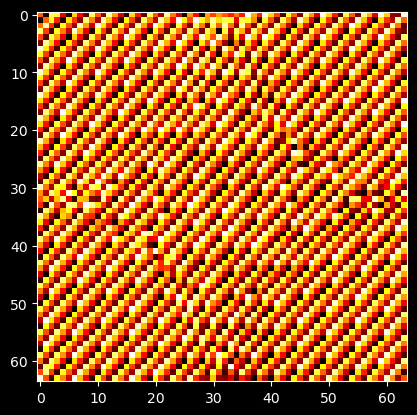

In [17]:
plt.imshow((y_1 * mask[:img_size**2]).reshape(64, 64).angle().cpu(), "hot")

In [29]:
import json
file = open("../ncsnpp_probes_g_64_230604024652/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

In [31]:
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t

def logprob_likelihood(x, cov_mat): 
    dist = torch.distributions.MultivariateNormal(loc = torch.zeros(obs_dim, device = x.device), covariance_matrix = cov_mat, validate_args=False)
    return dist.log_prob(x)

def f(x): 
    ft = torch.fft.fft2(x.reshape(img_size, img_size), norm = "ortho").flatten()
    ft_rep = torch.cat([ft.real, ft.imag])
    return ft_rep

def score_likelihood(x, t): 
    return vmap(grad(lambda x, t: logprob_likelihood(y- f(x)[mask],  (sigma_likelihood ** 2 + sigma(t)**2) * torch.eye(obs_dim, device = x.device))))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_model.score(t, x.reshape(-1, 1, img_size, img_size)).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([2, img_size ** 2]).to(device) 
t = torch.ones([2]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 4.00 GiB total capacity; 2.98 GiB already allocated; 0 bytes free; 3.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [21]:

def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

def reverse_euler_maruyama(x, t, dt, score_function): 
    z = torch.randn_like(x).to(device)
    dx = -g(t).reshape(-1,1)**2 * score_function(x,t) * dt + g(t).reshape(-1,1) * z * (-dt) ** (1/2)
    return x + dx
num_steps = 10000
dt = - 1 / num_steps
reverse_euler_maruyama(x, t, dt, score_posterior)


tensor([[ -5.7070,   2.5728,  -8.4214,  ...,  -5.8214,  -2.7349,   2.4428],
        [-28.2858,  -5.6456, -30.8349,  ...,  -9.7193, -20.6535,  14.4808]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [22]:
iterations = 500
batch_size = 1
x = (torch.randn([batch_size, img_size**2]) * sigma_max).to(device)
t = torch.ones(batch_size).to(device)
dt = -1/iterations
X = []

with torch.no_grad():
    with tqdm(range(iterations)) as pbar: 
        for i in pbar:
            x = reverse_euler_maruyama(x, t, dt, score_posterior)

100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


In [23]:

def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

"""
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x)
            x_mean  = x + (-0.5 * beta(t) * x - beta(t) * gradient) * dt 
            noise = (beta(t) * -dt) ** 0.5 * z 
            x = x_mean + noise
            t += dt
    return x_mean
"""
def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            
    return x_mean


#pc_samples = pc_sampler(num_samples = 100, num_pred_steps = 500, num_corr_steps = 20, snr = 1e-2, score_function = score_posterior, img_size = 28)
euler_samples = euler_sampler(num_samples = 1, num_steps = 500, score_function = score_posterior, img_size = img_size)


  3%|▎         | 15/499 [00:04<02:13,  3.63it/s]


KeyboardInterrupt: 

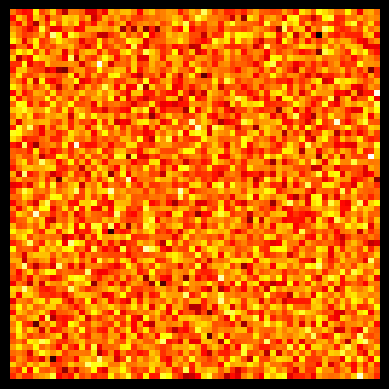

In [25]:
n_images = len(x)

if n_images != 1:
    fig, axs = plt.subplots(1, n_images, figsize = (8, 4))

    for i in range(n_images): 
        axs[i].imshow(x[i].cpu().reshape(img_size, img_size), cmap = "hot")
        axs[i].axis("off")
else: 
    plt.imshow(x.cpu().reshape(img_size, img_size), cmap = "hot")
    plt.axis("off")

In [14]:
x.min()

tensor(-570.8136, device='cuda:0')